In [90]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

from src.preprocesses import VTFPreprocessor, TargetPreprocessor, InfodrawPreprocessor
from src.dataloaders import load_data_dict_from_yaml

# infodraw, target 설정

In [96]:
model = nn.Linear(21, 1, bias=False)
init.constant_(model.weight.data, 1/21)

fpath = torch.rand(1, 21, 3, 3)
infodraw = torch.tensor([[[
    [1,    0.98, 0.3 ],
    [0.99, 0.34, 0.8 ],
    [0.29, 0.81, 0.99],
]]])
target = torch.tensor([[[
    [1,    1,    0],
    [1,    0,    1],
    [0,    1,    1],
]]])

print(f"fpath: {fpath.shape}, infodraw: {infodraw.shape}, target: {target.shape}")

def binary_cross_entropy_loss(y_hat, y):
    return -(y * torch.log(y_hat+1e-8) + (1-y) * torch.log(1-y_hat+1e-8))

fpath: torch.Size([1, 21, 3, 3]), infodraw: torch.Size([1, 1, 3, 3]), target: torch.Size([1, 1, 3, 3])


# 민교수님이 원하시는 방식

In [97]:
threshold = 0.99
sum_loss = 0
noise_pixel_cnt = 0

min_fpath = []
min_target = []
for h in range(3):
    for w in range(3):
        if infodraw[0, 0, h, w] < threshold:
            print(f"h: {h}, w: {w}")            
            min_fpath.append(fpath[0, :, h, w])
            min_target.append(target[0, 0, h, w])

sum_loss = 0

for fpath_pix, target_pix in zip(min_fpath, min_target):
    y_hat = model(fpath_pix)
    y_hat = torch.sigmoid(y_hat)
    cur_loss = binary_cross_entropy_loss(y_hat, target_pix)
    sum_loss += cur_loss
    print(f"y_hat: {y_hat.item()}, cur_loss: {cur_loss.item()}")

total_loss = sum_loss / len(min_fpath)
print(f"sum_loss: {sum_loss.item()}, noise_cnt: {noise_pixel_cnt} total_loss = {total_loss.item()}")        

h: 0, w: 1
h: 0, w: 2
h: 1, w: 1
h: 1, w: 2
h: 2, w: 0
h: 2, w: 1
y_hat: 0.6214919686317444, cur_loss: 0.47563228011131287
y_hat: 0.6273964643478394, cur_loss: 0.9872403144836426
y_hat: 0.6291754841804504, cur_loss: 0.9920263290405273
y_hat: 0.6316820979118347, cur_loss: 0.459369033575058
y_hat: 0.6332951784133911, cur_loss: 1.0031980276107788
y_hat: 0.6454753279685974, cur_loss: 0.43776828050613403
sum_loss: 4.355234146118164, noise_cnt: 0 total_loss = 0.7258723378181458


# 지금까지 해왔던 mask 적용한 계산

In [98]:
# model = nn.Linear(21, 1, bias=False)
# init.constant_(model.weight.data, 1/21)

threshold = 0.99
mask = (infodraw < threshold).float()

print(fpath.shape)
fpath = fpath.permute((0, 2, 3, 1))
y_hat = model(fpath)
y_hat = y_hat.permute((0, 3, 1, 2))
y_hat = torch.sigmoid(y_hat)
print(f"y_hat: {y_hat}")
total_loss = binary_cross_entropy_loss(y_hat, target)
print(f"total_loss: {total_loss}")
masked_loss = mask * total_loss
print(f"masked_loss: {masked_loss}")

loss = torch.sum(masked_loss) / torch.sum(mask)
print(f"loss: {loss.item()}")

torch.Size([1, 21, 3, 3])
y_hat: tensor([[[[0.6279, 0.6215, 0.6274],
          [0.6210, 0.6292, 0.6317],
          [0.6333, 0.6455, 0.6324]]]], grad_fn=<SigmoidBackward0>)
total_loss: tensor([[[[0.4653, 0.4756, 0.9872],
          [0.4765, 0.9920, 0.4594],
          [1.0032, 0.4378, 0.4582]]]], grad_fn=<NegBackward0>)
masked_loss: tensor([[[[0.0000, 0.4756, 0.9872],
          [0.0000, 0.9920, 0.4594],
          [1.0032, 0.4378, 0.0000]]]], grad_fn=<MulBackward0>)
loss: 0.7258723378181458


In [5]:
class JoonoFPathLazyDataset(Dataset):
    def __init__(self, config_path) -> None:
        super().__init__()
        self.data = load_data_dict_from_yaml(config_path)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        vtf_path        = self.data[index]['vtf']
        target_path     = self.data[index]['target']
        infodraw_path   = self.data[index]['infodraw']
        
        fpath           = VTFPreprocessor.get(vtf_path=vtf_path)
        target          = TargetPreprocessor.get(target_path=target_path)
        infodraw        = InfodrawPreprocessor.get(infodraw_path=infodraw_path)
        mask = (infodraw < 0.99).float()
        
        return fpath, target, mask

class JoonoModel(nn.Module):
    def __init__(self, in_channel=21, out_channel=1):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.layer1 = nn.Sequential(
            nn.Linear(21, 128, bias=True),
            nn.LayerNorm(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )
        
    def forward(self, fpath):
        out = fpath.permute((0, 2, 3, 1))
        out = self.layer1(out)
        out = out.permute((0, 3, 1, 2))
        
        return torch.sigmoid(out)

In [6]:
joono_dset = JoonoFPathLazyDataset(config_path="dataset/test.yaml")
joono_dloader = DataLoader(joono_dset, batch_size=1, num_workers=24)

joono_model = JoonoModel()
joono_optimizer = optim.Adam(joono_model.parameters(), lr=1e-3)

In [9]:
joono_model = joono_model.train()
for epoch in range(1):
    sum_loss = 0
    for fpath, target, mask in tqdm(joono_dloader):
        y_hat = joono_model(fpath)
        
        loss = binary_cross_entropy_loss(y_hat, target)
        loss = mask * loss
        loss = torch.sum(loss) / torch.sum(mask)
        sum_loss += loss.item()
        
        joono_optimizer.zero_grad()
        loss.backward()
        joono_optimizer.step()
    
    print(f"epoch: {epoch:3d} || train_loss: {sum_loss / len(joono_dloader)}")
torch.save(joono_model, "weights/joono_model.pth")

In [78]:
class MinFPathLazyDataset(Dataset):
    def __init__(self, config_path) -> None:
        super().__init__()
        self.data = load_data_dict_from_yaml(config_path)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        vtf_path        = self.data[index]['vtf']
        target_path     = self.data[index]['target']
        infodraw_path   = self.data[index]['infodraw']
        
        fpath           = VTFPreprocessor.get(vtf_path=vtf_path)
        infodraw        = InfodrawPreprocessor.get(infodraw_path=infodraw_path)
        target          = TargetPreprocessor.get(target_path=target_path)
        
        _, H, W = infodraw.shape
        fpath_list, target_list = [], []
        cnt = 0
        for h in range(H):
            for w in range(W):
                if infodraw[0, h, w] < 0.99:
                    cnt += 1
                    fpath_list.append(torch.tensor(fpath[:, h, w]))
                    target_list.append(target[0, h, w])
        
        print(f"cnt : {cnt}")
        fpath_list_tensor = torch.stack(fpath_list, dim=0)
        target_list_tensor = torch.stack(target_list, dim=0)
        
        return fpath_list_tensor, target_list_tensor
    
    
class MinsModel(nn.Module):
    def __init__(self, in_channel=21, out_channel=1):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.layer1 = nn.Sequential(
            nn.Linear(21, 128, bias=True),
            nn.LayerNorm(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )
        
    def forward(self, fpath_list_tensor):
        y_hat = self.layer1(fpath_list_tensor)
        
        return torch.sigmoid(y_hat)

In [79]:
min_dset = MinFPathLazyDataset(config_path="dataset/test.yaml")
min_dloader = DataLoader(min_dset, batch_size=1, num_workers=24)

min_model = MinsModel()
min_optimizer = optim.Adam(min_model.parameters(), lr=1e-3)

In [80]:
dummy_input = torch.rand(1, 100, 21)
y_hat = min_model(dummy_input)
print(f"y_hat: {y_hat.shape}")

y_hat: torch.Size([1, 100, 1])


In [81]:
min_model = min_model.train()
for epoch in range(1):
    sum_loss = 0
    for fpath_list, target_list in tqdm(min_dloader):
        y_hat = min_model(fpath_list)
        
        loss = binary_cross_entropy_loss(y_hat, target_list)
        loss = torch.mean(loss)
        print(f"\tepoch: {epoch:3d} || step_loss: {loss.item()}")
        sum_loss += loss.item()
        
        min_optimizer.zero_grad()
        loss.backward()
        min_optimizer.step()
    
    print(f"epoch: {epoch:3d} || train_loss: {sum_loss / len(min_dloader)}")
torch.save(min_model, "weights/min_model.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

cnt : 33209
cnt : 44437
cnt : 47812
cnt : 48238
cnt : 49221
cnt : 52328cnt : 57416

cnt : 58298
cnt : 59016
cnt : 61357
cnt : 47565
cnt : 55629
cnt : 64616
cnt : 53600
cnt : 63141
cnt : 57741
cnt : 64093
cnt : 68125
cnt : 67080
cnt : 61314
cnt : 59400
cnt : 63186
cnt : 65120
cnt : 63945
cnt : 46233
cnt : 59061
cnt : 51542
cnt : 47152
cnt : 60191
cnt : 65513
cnt : 52171
cnt : 57436
cnt : 54056
cnt : 58389
cnt : 47912
cnt : 49394
cnt : 68735
cnt : 51888
cnt : 46582
cnt : 51033
cnt : 62967
cnt : 72227cnt : 67966

cnt : 66537
cnt : 68004
cnt : 61393
cnt : 73099
cnt : 81105


  0%|          | 0/100 [00:21<?, ?it/s]


KeyboardInterrupt: 

In [87]:
def Min_inference(min_model, fpath, infodraw):
    min_model = min_model.eval()
    
    result = infodraw.clone()
    B, _, H, W = infodraw.shape
    
    cnt, cnt_B, cnt_W = 0, 0, 0
    for h in tqdm(range(H-1)):
        for w in range(W-1):
            if infodraw[0, 0, h, w] < 0.99:
                cnt += 1
                y_hat = min_model(fpath[0, :, h, w])
                y_hat = torch.sigmoid(y_hat)
                result[0, 0, h, w] = (y_hat > 0.5).float()
                
                if y_hat > 0.5:
                    cnt_W += 1
                else:
                    cnt_B += 1
    print(f"cnt: {cnt}, cnt_B: {cnt_B}, cnt_W: {cnt_W}")
    
    return result

In [88]:
fpath = VTFPreprocessor.get("/home/work/joono/VTFSketch/dataset/simple_data/test/vtfs/color_901_fpath_of_infodraw.npz")
infodraw = InfodrawPreprocessor.get("/home/work/joono/VTFSketch/dataset/simple_data/test/infodraws/color_901_out.png")

fpath_tensor = torch.tensor(fpath).unsqueeze(0)
infodraw_tensor = torch.tensor(infodraw).unsqueeze(0)

min_result = Min_inference(min_model, fpath=fpath_tensor, infodraw=infodraw_tensor)
print(f"min: {torch.min(min_result)}, max: {torch.max(min_result)}")

/tmp/ipykernel_1242/778551334.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  infodraw_tensor = torch.tensor(infodraw).unsqueeze(0)
100%|██████████| 1023/1023 [00:13<00:00, 77.47it/s]

cnt: 57678, cnt_B: 0, cnt_W: 57678
min: 0.4431372582912445, max: 1.0


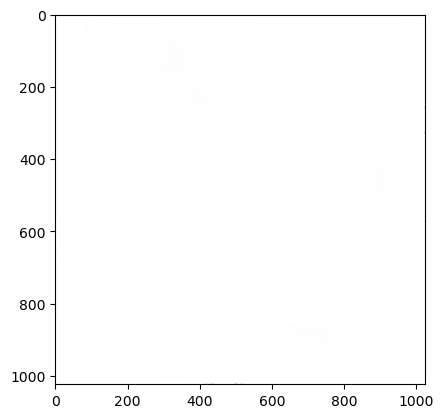

In [89]:
plt.imshow(min_result.squeeze().detach().cpu(), cmap='gray')

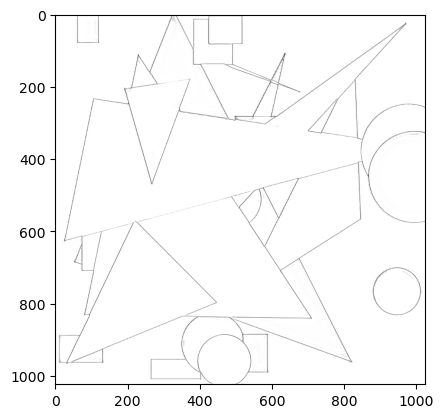

In [74]:
plt.imshow(infodraw.squeeze(), cmap='gray')

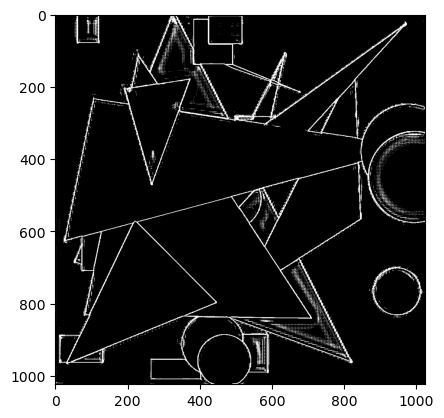

In [33]:
plt.imshow(infodraw.squeeze() < 0.99, cmap='gray')

In [65]:
def Joono_inference(joono_model, fpath, infodraw):
    joono_model = joono_model.eval()
    
    result = infodraw.clone()
    mask = infodraw < 0.99
    
    y_hat = joono_model(fpath)
    y_hat = torch.sigmoid(y_hat)
    
    result = mask * y_hat + ~mask * infodraw
    
    return result

In [69]:
joono_result = Joono_inference(joono_model, fpath=fpath_tensor, infodraw=infodraw_tensor)
print(f"min: {torch.min(joono_result)}, max: {torch.max(joono_result)}")

min: 0.5137227773666382, max: 1.0


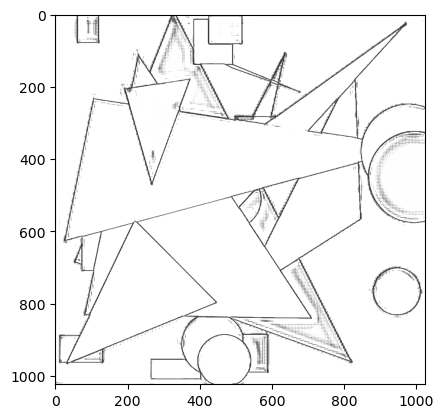

In [68]:
plt.imshow(joono_result.squeeze().detach().cpu(), cmap='gray')